# **22. 사람의 몸짓을 읽어보자**

## **22-1. 들어가며**

### **Human Pose Estimation with Keypoint detection**
---

틱톡이라는 앱 사용해 보신 적 있으신가요? 저는 안 써봤지만 전 세계적으로 인기를 끌고 있는 애플리케이션입니다.

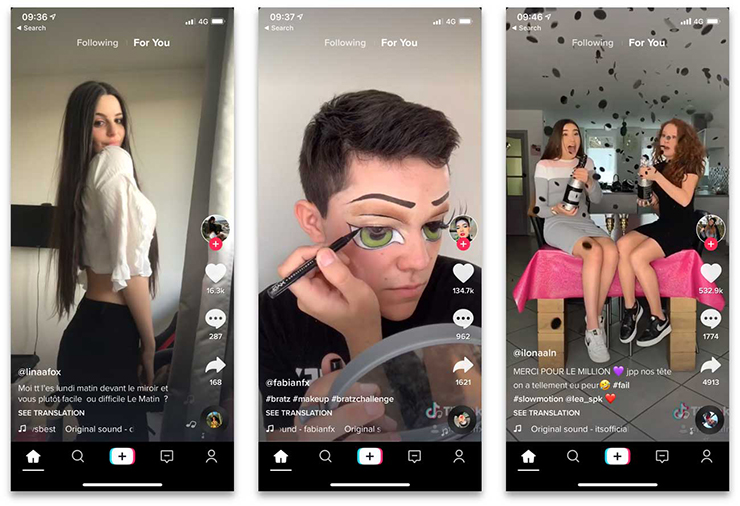

https://www.doorcreative.com/magazine19/1020-

지금까지 우리가 만들어온 얼굴인식 애플리케이션과 다르게 전신이 등장하는 것도 색다른 특징인데요!<br>
<br>
나만의 카메라 앱을 스노우와 같은 얼굴인식뿐만 아니라 더 넓은 범위로 사용할 수 있다면 세상에 없던 것을 만들 수 있지 않을까요?<br>
<br>
오늘은 새로운 기능인 **human pose estimation**에 대한 개념과 이론에 대해 알아보도록 하겠습니다.

**[아이스브레이킹] pose estimation 기술은 실생활에서 어떻게 활용되고 있을까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

운동 분야에서는 Pose estimation 기술을 활용하여 사용자의 자세를 분석하고 잘못된 자세를 감지하여 경고나 피드백을 제공해줍니다.<br>
<br>
그 외에도 VR/AR 게임, 영화 및 애니메이션 제작, 로봇 제어, 의료, 자율 주행, 보안 등 다양한 분야에서 Pose estimation 기술이 활용되고 있고, 또 활용될 수 있습니다!</details>

## **22-2. body language, 몸으로 하는 대화**

Human pose estimation(HPE)은 크게 2D와 3D 로 나누어집니다.<br>
*(짧게 HPE 라고 부를게요. 공식 용어는 아닙니다.🤓)*<br>
<br>
2D HPE 는 2D 이미지에서 (x, y) 2차원 좌표들을 찾아내고, 3D HPE 는 2D 이미지에서 (x, y, z) 3차원 좌표들을 찾아내는 기술입니다.<br>
<br>
그런데, 2차원 이미지에서 3차원 이미지를 복원하는 일은 굉장히 어려운 일입니다.<br>
<br>
- [영상 Geometry #1 좌표계](https://darkpgmr.tistory.com/77)
- [영상 Geometry #7 Epipolar Geometry](https://darkpgmr.tistory.com/83?category=460965)

**Q. 2차원 이미지에서 3차원 이미지를 복원하는 일이 왜 어려울까요? 위 링크를 참고해서 대답해 봅시다.**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

A. **(직관적인 예시)** 2D 영상에서는 큰 원통이 멀리 있는 것과 작은 원통이 가까이 있는 것을 구분할 수 없습니다.<br>
**(이론적인 설명)** 카메라 행렬에서 [x y z] real world 좌표가 이미지 [u v] 좌표계로 표현될 때 z 축(거리 축) 정보가 소실되기 때문입니다.</details>

굉장히 어렵긴 하지만 사람의 몸은 3D 환경에서 제약이 있습니다.<br>
(실세계 좌표계에서) 발은 바닥에 있으면서 무릎은 머리 위로 갈 수 없듯이 말이죠. 그래서 이런 제약 조건을 이용해서 어느 정도 문제를 해결할 수 있습니다.<br>
<br>
3D pose estimation 을 깊이 있게 다루기는 매우 오랜 시간이 걸리기 때문에, 오늘은 2D 영상 내에서 (x, y) pose (관절) 의 위치를 찾는 방법을 다뤄보려 합니다.

## **22-3. Pose 는 face landmark 랑 비슷해요**

사실 우리는 이미 2D pose estimation 을 다룬 적이 있습니다. face landmark 와 매우 비슷하지 않나요?<br>
맞습니다. 딥러닝이나 사람의 시각에서도 실제로도 매우 비슷한 애플리케이션입니다. 입력과 출력이 개수만 다를 뿐 상당히 비슷하죠.<br>
<br>
하지만 난이도에서 차이가 납니다.<br>
face landmark 는 물리적으로 거의 고정되어 있는 (입이 얼굴보다 클 수 없는 걸 생각해 주세요😃) 반면, human pose 는 팔, 다리가 상대적으로 넓은 범위와 자유도를 갖는다는 것을 고려해야 합니다.

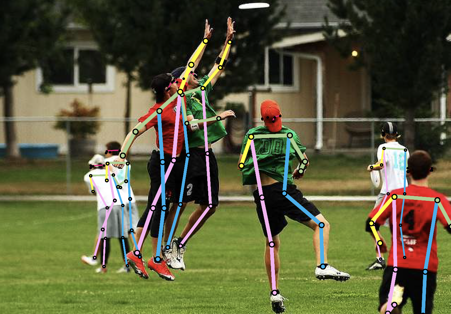

자유도가 높다는 것은 데이터 분포를 특정하기 어렵다고 표현할 수 있을 것 같습니다. 데이터 분포를 학습하기 어렵다면 당연히 학습에 더 많은 데이터가 필요하고 더 복잡한 모델을 사용해야 한다는 것을 의미합니다.<br>
<br>
따라서 상당히 많은 사전 작업이 요구되고 사용하려는 애플리케이션에 따라 접근 방법도 달라집니다.<br>
<br>
가장 초기에 만나는 접근법은 두 가지로 나눠질 수 있습니다.

### **우리에게 맞는 방법은 뭘까?**

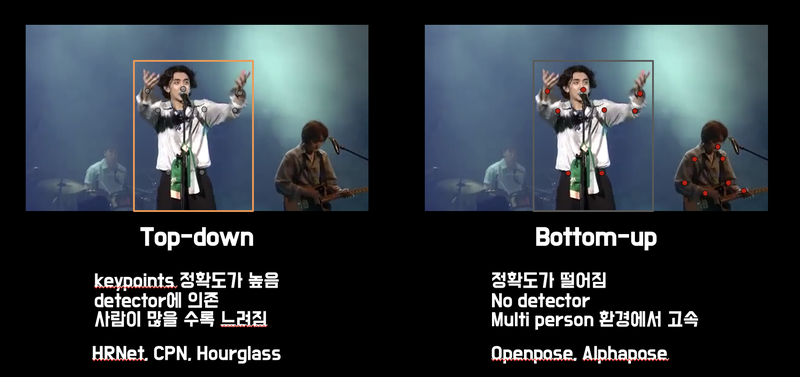

첫 번째 방법은 **Top-down** 방법입니다.<br>
<br>
- 모든 사람의 정확한 keypoint 를 찾기 위해 **object detection** 을 사용합니다.
- crop 한 이미지 내에서 keypoint 를 찾아내는 방법으로 표현합니다.
- detector가 선행되어야 하고 모든 사람마다 알고리즘을 적용해야 하기 때문에 사람이 많이 등장할 때는 느리다는 단점이 있습니다.
<br><br>

두 번째 방법은 **Bottom-up** 방법입니다.<br>
<br>
- detector가 없고 **keypoint 를 먼저 검출**합니다.<br>
예를 들어 손목에 해당하는 모든 점들을 검출합니다.
- 한 사람에 해당하는 keypoint 를 clustering 합니다.
- detector 가 없기 때문에 다수의 사람이 영상에 등장하더라도 속도 저하가 크지 않습니다. 반면 top down 방식에 비해 keypoint 검출 범위가 넓어 성능이 떨어진다는 단점이 있습니다.<br><br>

얼마나 정확해야 하는지, 여러 사람이 등장하는지에 따라서 필요한 알고리즘이 달라질 수 있습니다. 핸드폰 카메라로 찍는 인물들은 대체로 소수로 등장하기 때문에 top-down 방식을 이용해도 큰 속도 저하 없이 사용할 수 있을 것이라 생각합니다.<br>
<br>
그럼 Top-down 방법들에 대해 자세히 알아보겠습니다.

**Q. Pose estimation 기술은 일반적으로 top-down 방식과 bottom-up 방식으로 구현될 수 있는데요, 각 방식의 장ㆍ단점에 대해서 생각해볼까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

Top-down 방식은 이미지에서 객체(사람)를 먼저 찾고, 찾은 객체의 Bounding box에서 자세를 추정합니다. 원하는 객체를 먼저 검출한 뒤에 그 객체에서의 keypoint를 찾기 때문에 정확도가 Bottom-up 방식보다 상대적으로 높습니다. 단, 검출된 객체들을 순회하면서 keypoint를 찾는 것이기 때문에 상대적으로 느리다는 단점이 있습니다.<br>
<br>
Bottom-up 방식은 이미지에서 keypoint들을 먼저 찾고, keypoint들의 상관관계를 분석하여 이들을 연결해 자세를 추정합니다. 정확도는 Top-down 방식에 비해서 떨어질 수 있지만, Detection 과정이 없기 때문에 속도가 빨라 실시간 처리에 활용이 가능하다는 장점이 있습니다.</details>

## **22-4. human keypoint detection (1)**

### **자유도가 높은 사람의 동작**
---

위 챕터에서 설명한 것처럼 human pose estimation 은 keypoint 의 localization 문제를 푼다는 점에서 비슷합니다. 하지만 손목, 팔꿈치 등의 joint keypoint 정보는 얼굴의 keypoint 보다 훨씬 다양한 위치와 변화를 보입니다.

<img src="https://github.com/Team-Neighborhood/Kalman-Filter-Image/raw/master/result/KF_result.gif">

https://github.com/Team-Neighborhood/Kalman-Filter-Image

위 이미지에서 볼 수 있듯이 손이 얼굴을 가리는 행위, 모든 keypoint 가 영상에 담기지 않는 등 invisible , occlusions, clothing, lighting change 가 face landmark 에 비해 더 어려운 환경을 만들어 냅니다.<br>
<br>
딥러닝 기반 방법이 적용되기 전에는 다양한 사전 지식이 사용되었습니다.<br>
가장 기본이 되는 아이디어는 "인체는 변형 가능 부분으로 나누어져 있고 각 부분끼리 연결성을 가지고 있다." 는 것입니다.

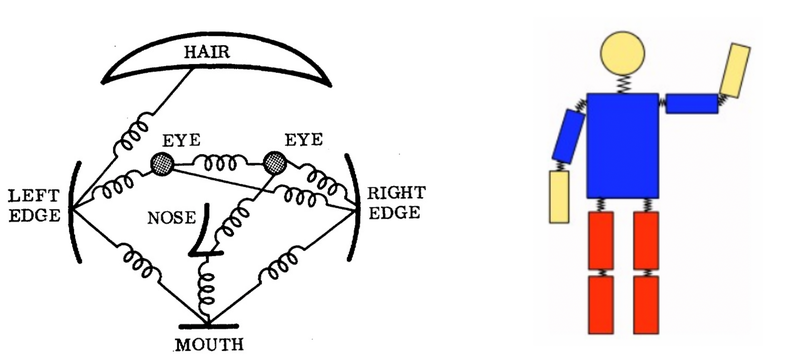

https://nanonets.com/blog/human-pose-estimation-2d-guide/

그림에서 보이는 것처럼 손은 팔, 팔은 몸과 연결되어 있습니다. 손이 다리 옆에 있을 확률이 팔 옆에 있을 확률보다 훨씬 작을 것입니다. 이런 제약 조건을 그림에 보이는 스프링으로 표현했습니다.<br>
<br>
3D 환경에서 생각하면 정말 좋은 방법입니다. 하지만 우리가 다루는 데이터는 2D 이미지 데이터이기 때문에 촬영 각도에 따라 충분히 팔이 다리 옆에서 관찰될 수 있습니다.<br>
<br>
이 문제를 해결하기 위해 Deformable part models 방법에서는 각 부분(part) 들의 complex joint relationship 의 mixture model 로 keypoint 를 표현하는 방법을 이용했지만 성능은 사람들의 기대에 미치지 못했습니다. 자세한 내용은 아래 논문을 참고해 보세요.<br>
<br>
- [Articulated human detection with flexible mixtures-of-parts](https://www.cs.cmu.edu/~deva/papers/pose_pami.pdf)

**Q. deformable part model 은 ____ 들의 모음으로 구성 됩니다. ____ 은 global 과 part 두 가지 종류로 나누어져 있습니다. 빈칸에 들어갈 단어는 무엇일까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

template</details>

### **DeepPose**
---

딥러닝 이전의 전통적 pose estimation 모델은 분명한 한계가 있습니다. deformable parts model 논문에서 언급했듯이 graphical tree model 은 같은 이미지에 두 번 연산을 하는 등 연산 효율이 떨어지는 점과 그에 비해서도 부족한 성능이 문제점으로 인식되어 왔습니다.<br>
<br>
AlexNet 이후, 다양한 분야에 CNN 이 적용되면서 pose estimation 분야에도 CNN 을 이용한 방법이 나타나기 시작했습니다. Toshev and Szegedy 는 처음으로 딥러닝 기반 keypoint localization 모델을 제안했습니다.<br>
<br>
- [DeepPose: Human Pose Estimation via Deep Neural Networks](https://arxiv.org/pdf/1312.4659.pdf)

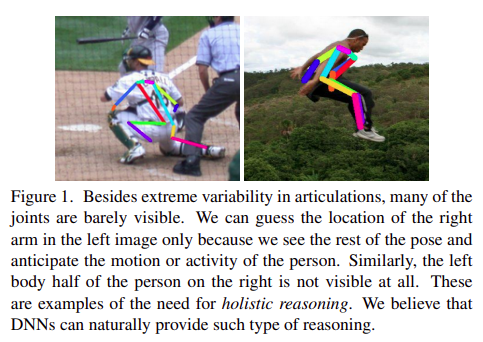

기존 기술로는 풀기 어려웠던 동작의 다양성, invisible joint 의 문제를 언급하며 딥러닝 기반 추론 방법이 해결책이 될 수 있다는 것을 증명 해냈습니다.

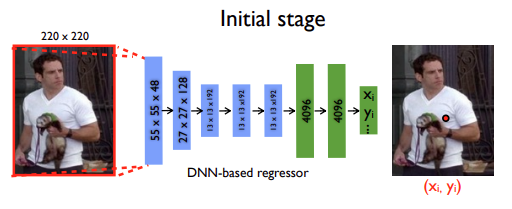

초기의 pose estimation 모델은 x,y 좌표를 직접적으로 예측하는 position regression 문제로 인식했습니다. human detection 을 통한 crop 된 사람 이미지를 이용해서 딥러닝 모델에 입력하고 (x,y) 좌표를 출력하도록 만듭니다.

**Q. position regression 인 DeepPose는 어떤 loss 함수를 썼을까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

L2 Loss</details>

DeepPose는 매우 혁신적인 시도였던 것에 비해 사실 성능이 압도적으로 높았던 것은 아닙니다.

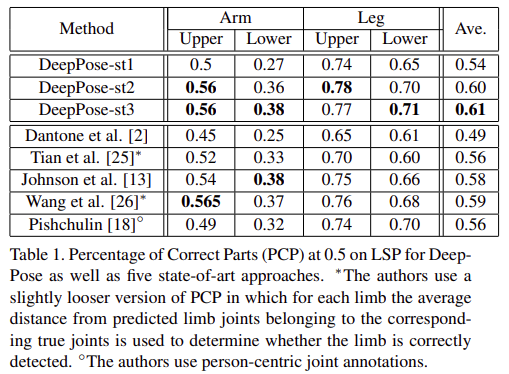

표에서 볼 수 있듯이 DeepPose 가 전반적으로 높은 성능을 나타내고 있긴 하지만 기존 Tree based model 인 Wang et al. 의 방법에 비해 비약적으로 성능을 상승시켰다고 말하기는 어렵습니다. DeepPose 의 기여는 **SOTA에 가까운 성능을 내면서도 딥러닝을 적용한 첫 번째 사례**라고 할 수 있겠습니다.

### **Efficient Object Localization Using Convolutional Network**
---

DeepPose는 딥러닝을 사용했는데 왜 성능이 비약적으로 상승하지 않았을까요? 저는 이 논문이 해결책을 제시하고 있다고 생각합니다.<br>
<br>
Tompson 이 제안한 Efficient object localization 방법을 간단하게 소개해 드리려고 합니다.

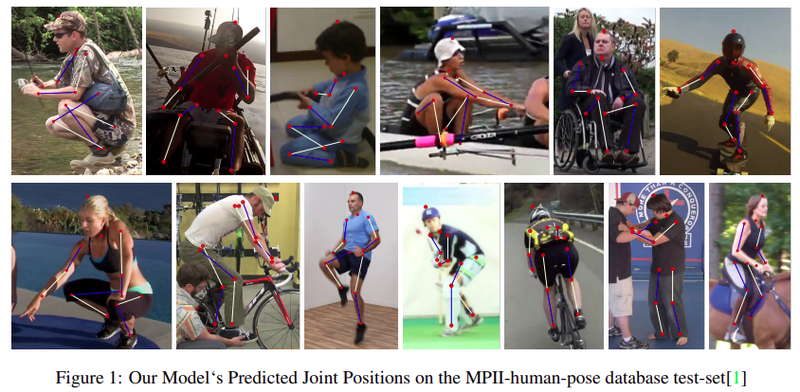

이 논문에서는 제안했던 모델도 DeepPose 에 비해 깊어졌지만, 가장 중요한 건 keypoint의 위치를 직접 예측하기보다 **keypoint가 존재할 확률 분포를 학습하게 하자**는 점입니다.

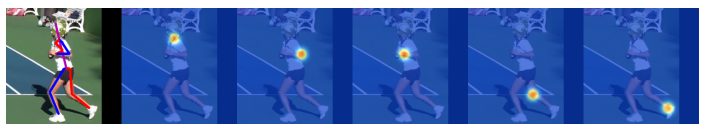

https://nanonets.com/blog/human-pose-estimation-2d-guide/

human pose (keypoint) 도 사람이 labeling 을 할 수밖에 없는데 사람이 항상 같은 위치의 점을 찍을 수 있을까요? 동영상으로 보면 조금 더 쉽게 관찰할 수 있습니다.<br>
동영상의 아래 keypoint 들을 유심히 바라봐 주세요. 귀는 귀에 눈은 눈에 그리고 어깨는 어깨에 keypoint 자체는 잘 찍혀 있는 것 같은데 어색하지 않나요?

<img src="https://github.com/Team-Neighborhood/Kalman-Filter-Image/raw/master/result/KF_result.gif">

https://github.com/Team-Neighborhood/Kalman-Filter-Image

Kalman filter 라고 적힌 동영상에 비해 Orig measured 는 점이 굉장히 떨리고 있다는 사실을 알 수 있습니다. 항상 같은 위치라고 생각하면서 keypoint 를 선택하지만 사실 매 사진마다 수 픽셀씩 차이가 생기고 있습니다. 눈을 찍고 싶다면 눈을 중심으로 "어떤 분포" 의 에러가 더해져서 저장되는 것이죠.<br>
<br>
자연상태에서 일어나는 확률 분포는 가우시안 분포일 가능성이 큽니다. Tompson 은 이런 점에 착안하여 label 을 (x,y) 좌표에서 (x,y) 를 중심으로 하는 heatmap 으로 변환했습니다. 딥러닝 모델은 이 heatmap 을 학습하게 되는 것이죠. **"keypoint 가 존재할 확률" 을 학습하게 된 이후로 성능이 비약적으로 향상**되는 모습을 볼 수 있습니다.

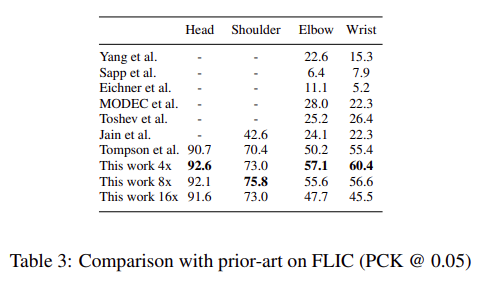

Toshev가 제안한 DeepPose 에 비해 무려 2배가 넘는 수치를 볼 수 있습니다. 머리의 경우 0.9 가 넘는 높은 성능을 드디어 가지게 됐습니다.

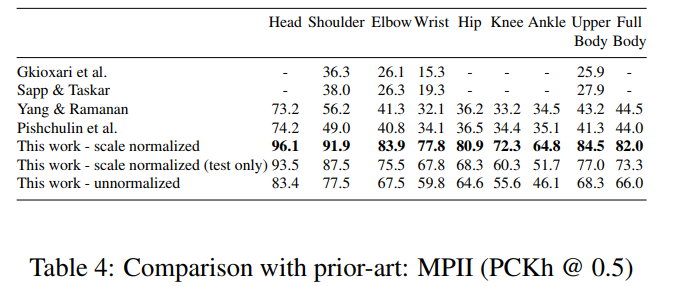

MPII 데이터는 2014년에 나온 데이터입니다. 기존 FLIC 데이터가 머리, 어깨, 팔꿈치, 손목 수준의 적은 개수의 keypoint를 가지고 있었지만 MPII는 몸의 각 관절 부위 16개의 keypoint를 갖습니다. 기존 논문 (Gkioxari, Sapp) 들이 일부 데이터가 없는 이유입니다.<br>
<br>
MPII 에 대해서는 실습 시간에 자세히 다뤄보겠습니다.<br>
<br>
Tompson 이 제안한 방법은 heatmap 학습뿐만이 아닙니다. 모델에서도 개선을 이뤘는데요, 어떤 방법이 있는지 논문에서 확인해 보시길 바랍니다.<br>
<br>
- [Efficient Object Localization Using Convolutional Networks](https://arxiv.org/pdf/1411.4280.pdf)

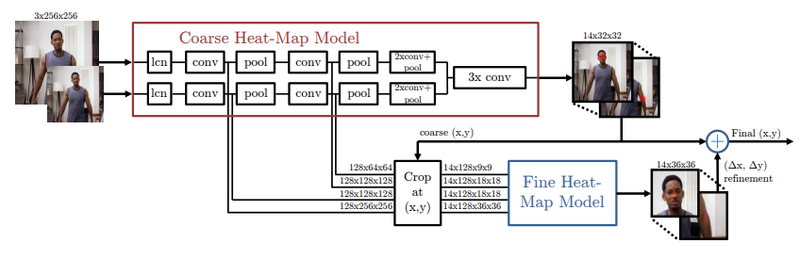

**Q. Tompson이 제안한 모델은 Coarse model 과 fine model 로 나누어집니다. 두 모델 간에 어떤 관계가 있을까요? 위 그림을 참고해 설명해 봅시다.**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

coarse model 에서 32x32 heatmap 을 대략적으로 추출한 후 multi resolution 입력을 coarse heatmap 기준으로 crop 한 뒤 fine model 에서 refinement 를 수행합니다.</details>

**Q. Tompson 이 제안한 모델에서 weight sharing 이 적용된 부분을 설명해 봅시다. 왜 그렇게 만들었을까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

coarse model 과 fine model 이 같은 모델이며 weight 를 공유합니다. 목적이 같기 때문에 빠른 학습이 가능하고 메모리, 저장공간을 효율적으로 사용할 수 있습니다.</details>

## **22-5. human keypoint detection (2)**

### **Convolutional Pose Machines**
---

CVPR 2016에서 발표된 CPM 은 completely differentiable 한 multi-stage 구조를 제안했습니다. multi stage 방법들은 DeepPose 에서부터 지속적으로 사용되어 왔었습니다.<br>
하지만 crop 연산 등 비연속적인 미분 불가능한 stage 단위로 나눠져 있었기 때문에 학습 과정을 여러 번 반복하는 비효율적인 방법을 사용해왔습니다.<br>
<br>
- [Convolutional Pose Machines](https://arxiv.org/pdf/1602.00134.pdf)<br><br>

CPM 은 end-to-end 로 학습할 수 있는 모델을 제안합니다.

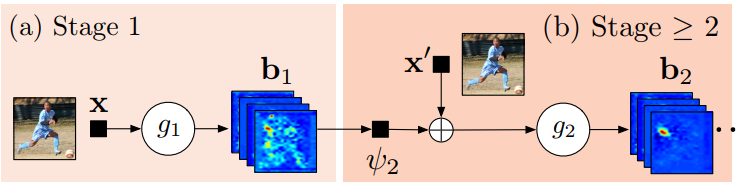

Stage 1 은 image feature 를 계산하는 역할을 하고 stage 2는 keypoint 를 예측하는 역할을 합니다. g1과 g2 모두 heatmap 을 출력하게 만들어서 재사용이 가능한 부분은 weight sharing 할 수 있도록 세부 모델을 설계했습니다.

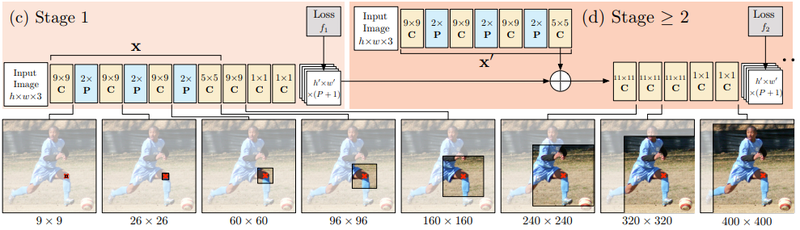

Stage ≥ 2 에서 볼 수 있듯이 stage 2 이상부터는 반복적으로 사용할 수 있습니다. 보통은 3개의 스테이지를 사용한다고 합니다. stage 1 구조는 고정이고 stage 2 부터는 stage 2 구조를 반복해서 추론합니다. stage 2 부터는 입력이 heatmap(image feature)이 되기 때문에 stage 단계를 거칠수록 keypoint가 refinement 되는 효과를 볼 수 있습니다.

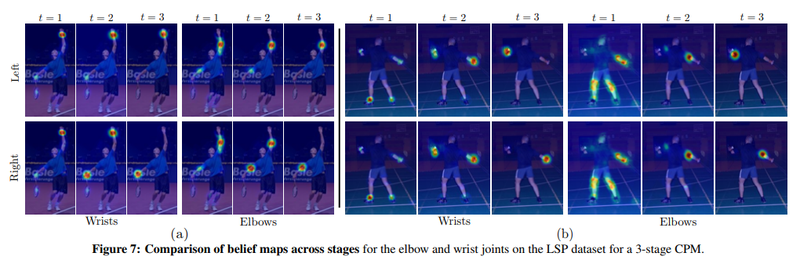

사실 CPM 이 아주 좋은 방법이라고는 말하기 어렵습니다. Multi-stage 방법을 사용하기 때문에 end-to-end 로 학습이 가능하더라도 그대로 학습하는 경우는 높은 성능을 달성하기 어렵습니다. 따라서 stage 단위로 pretraining 을 한 후 다시 하나의 모델로 합쳐서 학습을 합니다. 논문을 작성하기 위해서라면 충분히 감내할 수 있지만 서비스 측면에서 바라본다면 불편한 요소라고 할 수 있습니다. 이런 문제점들은 후에 제안되는 모델들이 적극적으로 개선하고 있습니다.<br>
<br>
CPM 을 다루는 이유는 성능 때문입니다. receptive field 를 넓게 만드는 multi stage refinement 방법이 성능 향상에 크게 기여한 것 같습니다.

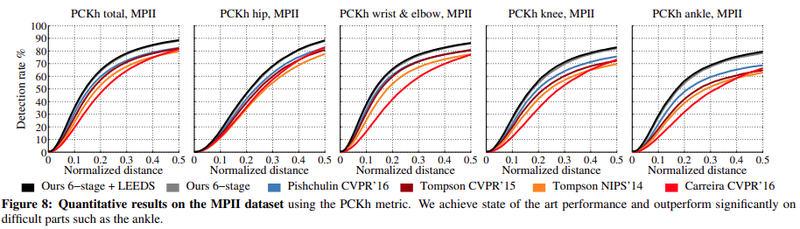

주황색 실선이 Tompson 알고리즘입니다. CPM 에서 제안한 검정색, 회색 실선이 detection rate에서 유의미한 차이를 보이고 있는 것을 볼 수 있습니다. MPII 의 PCKh\@0.5 에서 87.95% 를 달성했다고 합니다. 당시 2등보다 6.11%p 높은 성능을 보였습니다.

### **Stacked Hourglass Network**
---

ECCV16 에서는 DeepPose 이후 랜드마크라고 불릴만한 논문이 제안되었습니다. 바로 [Stacked Hourglass Networks for Human Pose Estimation](https://arxiv.org/pdf/1603.06937.pdf) 입니다.<br>
<br>
이름에 모든 내용이 담겨 있습니다. 하나씩 살펴보겠습니다.

###### Hourglass

**Stacked Hourglass Network** 의 기본 구조는 모래시계 같은 모양으로 만들어져 있습니다. Conv layer 와 pooling 으로 이미지(또는 feature) 를 인코딩 하고 upsampling layer 를 통해 feature map 의 크기를 키우는 방향으로 decoding 합니다. feature map 크기가 작아졌다 커지는 구조여서 hourglass 라고 표현합니다.

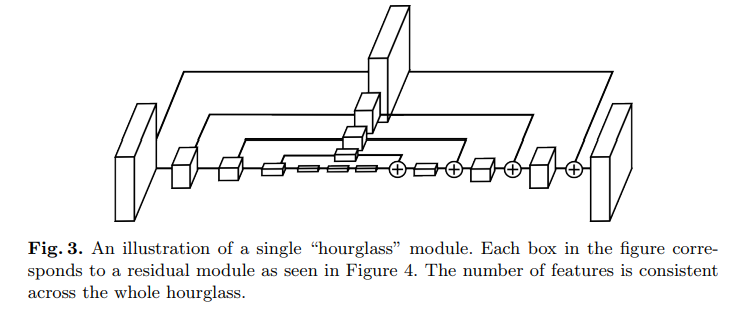

기존 방법들과의 가장 큰 차이점은<br>
<br>
1. feature map upsampling
2. residual connection<br><br>

이라고 할 수 있을 것 같습니다.<br>
<br>
pooling으로 image의 global feature를 찾고 upsampling으로 local feature를 고려하는 아이디어가 hourglass의 핵심 novelty라고 할 수 있습니다.<br>
<br>
[resnet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)은 이미 충분히 학습하셨을 테니, 복습해 보시기 바랍니다.<br>
<br>
hourglass의 모델 구조를 보면 [U-Net](https://arxiv.org/abs/1505.04597)과 비슷해 보입니다. 실제로 비슷하기도 하구요.<br>
<br>
Hourglass는 이 간단한 구조를 여러 층으로 쌓아올려서 (stacked) human pose estimation의 성능을 향상시켰습니다.

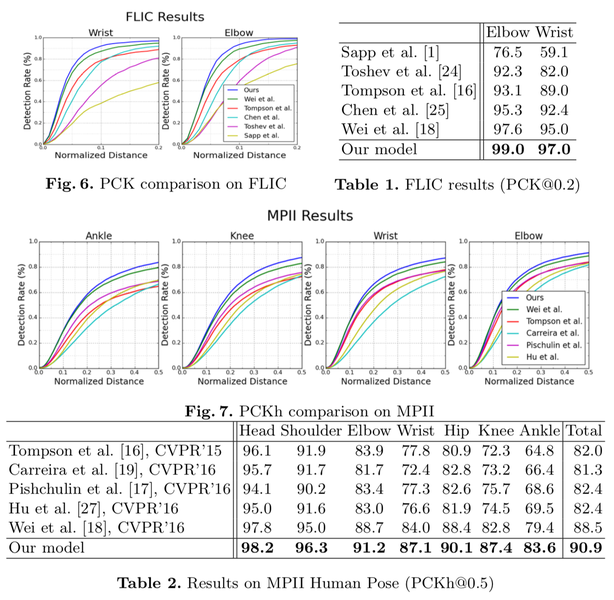

MPII 에서 처음으로 PCKh\@0.5 기준 90%를 넘어서는 성과를 보이게 됩니다. 특유의 간단한 구조와 높은 성능으로 현재까지도 많이 사용되고 있는 구조입니다. human pose 분야에 관심이 있으시다면 한 번 사용해 보시기를 권장해 드립니다.

### **SimpleBaseline**
---

앞서 소개해드린 연구들은 딥러닝 기반의 2D human pose estimation 이 어떻게 발전해 왔는지 보여주고 있습니다. (x, y) 를 직접 regression 하는 방법이 heatmap 기반으로 바뀌고 모델의 구조가 바뀌어 가면서 encoder-decoder 가 쌓아져 가는 형태가 완성되었습니다.<br>
<br>
결과적으로 MPII 에서 90% 를 넘길 정도로 좋아졌지만 모델의 구조는 다소 복잡해졌습니다.<br>
*사실 2020년 최신 논문들에 비하면 크게 복잡한 정도는 아니지만.. 18~19년 당시의 기준입니다.*<br>
<br>
HPE 의 연구를 쭉 따라오던 당시 Microsoft 인턴 Haiping Wu는 약간 다른 시각을 가져봤습니다.<br>
<br>
**"기술 자체가 많이 발전했는데 현재의 간단한 모델은 얼마나 성능이 좋을까?"**<br>
<br>
[SimpleBaseline](https://arxiv.org/pdf/1804.06208.pdf)의 저자는 정말 아주 간단한 encoder-decoder 구조를 설계합니다.

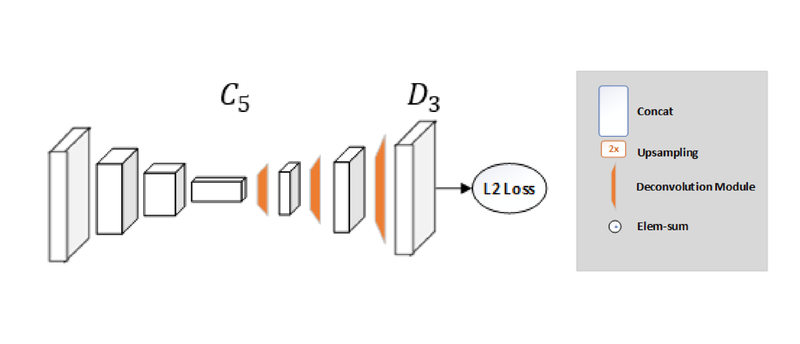

그리고 이 구조로 무려 '73.7%' 의 AP 를 COCO 에서 달성합니다. 직전 연도(2017년) 의 72.1% 결과를 뛰어넘는 수치입니다. 인턴 성과로 ECCV'18 에 출판되는 위엄을 보여주게 됩니다.

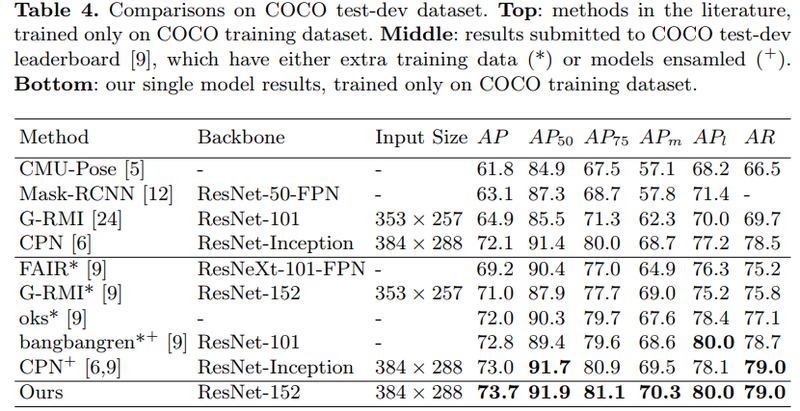

[COCO 에서 mAP 73.7 의 놀라운 수치를 보여줍니다.]

직전 방법인 hourglass 와 직접 비교해 보면, 아래와 같은 결과가 나온다고 합니다.

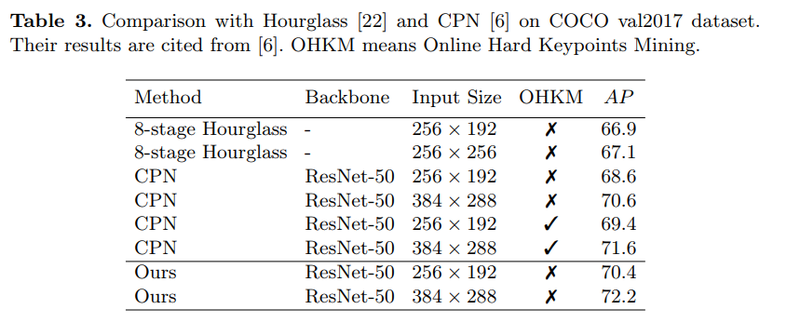

resnet 50 만 사용한 간단한 구조가 hourglass 와 같은 SOTA(state-of-the-art) 를 이겼다는 것에 큰 놀라움을 선물한 논문이라고 생각합니다.<br>
<br>
참고로 **CPN** 은 이전에 소개한 Convolutional Pose Machine 이 아닌 **Cascaded Pyramid Network** 라는 모델입니다. 자세히 소개 드리지는 않지만 skip connection 이 stage 사이에 연결되어 있다는 정도로 이해하고 넘어가시면 좋을 것 같습니다.<br>
<br>
SimpleBaseline은 구조가 간단하기 때문에 다뤄보기 좋을 것 같습니다. 다음 스텝에서 코드와 함께 살펴보도록 하겠습니다.

### **Deep High-Resolution Network (HRNet)**
---

[HRNet](https://arxiv.org/pdf/1902.09212.pdf) 은 개발된 이후 현재까지도 SOTA 에 가까운 성능을 보일 정도로 성능이 좋은 알고리즘입니다. Simplebaseline의 1저자가 참여해 연구한 모델이기 때문에 Simplebaseline과 같은 철학을 공유합니다.<br>
<br>
Stacked hourglass, Casecaded pyramid network 등은 multi-stage 구조로 이루어져 있어서 학습 & 추론 속도가 느리다는 큰 단점이 있습니다. (대신 하이퍼파라미터를 최적화할 경우 1-stage 방법보다 성능이 좋습니다.)<br>
반면 Simplebaseline 과 HRNet은 간단함을 추구하는 만큼 1-stage 를 고수합니다. 덕분에 구조도 간결해지고 사용하기도 쉽습니다.

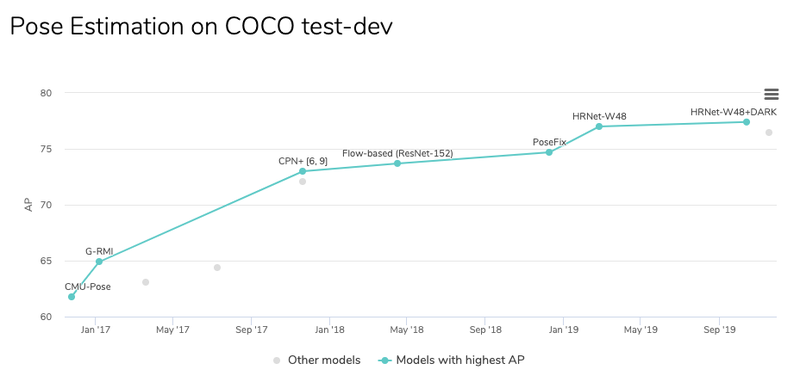

https://paperswithcode.com/sota/pose-estimation-on-coco-test-dev

COCO 데이터셋에서 한때 SOTA 의 성능을 자랑했습니다.<br>
<br>
1-stage 에서 어떻게 모델을 변화 시켰을까요? 기존 알고리즘들을 먼저 살펴보겠습니다.

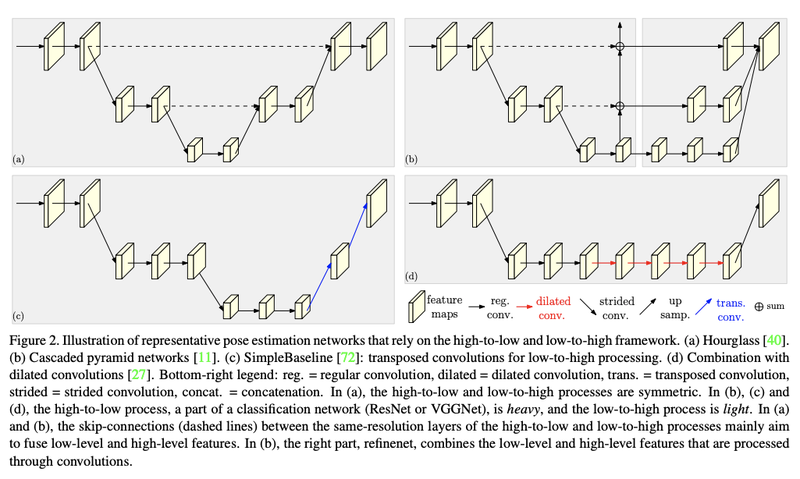

(a) : Hourglass<br>
(b) : CPN(cascaded pyramid networks)<br>
(c) : SimpleBaseline - transposed conv<br>
(d) : SimpleBaseline - dilated conv<br>
<br>
를 나타냈습니다.

**Q. 위 그림에서 Simplebaseline 이 다른 알고리즘들에 비해 성능이 떨어지지 않지만 구조를 보면 공통점과 차이점을 관찰할 수 있습니다. 어떤 공통점과 차이점이 있을까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

공통점 : high resolution → low resolution 인 encoder 와 low → high 인 decoder 구조로 이루어진 점<br>
차이점 : Hourglass 는 encoder 와 decoder 의 비율이 거의 비슷함(대칭적임). 반면 Simplebaseline 은 encoder 가 무겁고 (resnet50 등 backbone 사용) decoder 는 가벼운 모델을 사용함. (a), (b) 는 skip connection 이 있지만 (c) 는 skip connection 이 없다.</details>

**Q. 차이점에 조금 더 집중해보면 기존 모델들은 skip connection 을 적극적으로 사용했습니다. 왜 사용했을까요? Simplebaseline 도 사용해야하지 않을까요? 동료들과 의논해 봅시다.**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

pooling(strided conv) 할 때 소실되는 정보를 high level layer에서 사용해서 detail한 정보를 학습하기 위해 사용합니다. 당연히 사용할 때 성능이 더 좋을 것 같습니다.</details>

HRNet 저자도 앞의 질문들에 대해 고민을 했습니다. high → low → high 의 구조에서 high resolution 정보(representation)을 유지할 수 있는 모델을 어떻게 만들 수 있을까?

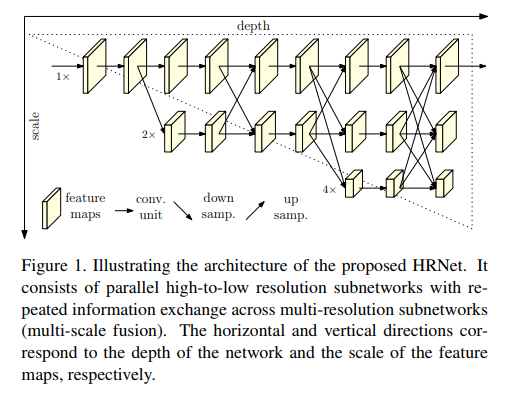

고민의 결과, down sample layer를 만들고 작아진 layer feautre 정보를 다시 up sampling해서 원본 해상도 크기에 적용하는 모델을 제안했습니다. 다소 복잡해 보이지만 1-stage로 동작하기 때문에 전체 flow를 보면 엄청 간단합니다. 우리가 앞에서 다뤘던 CPM이나 Hourglass는 중간 단계에서의 heatmap supervision이 학습과정에 꼭 필요했는데 HRNet 은 필요가 없습니다!!<br>
<br>
구현도 Simplebaseline의 backbone인 Resnet을 HRNet으로 교체만 해주면 되기 때문에 사용하기도 굉장히 편리합니다. 정말 멋지지 않나요?<br>
<br>
HRNet 또한 이전 알고리즘 들과 마찬가지로 heatmap을 regression하는 방식으로 학습하고 MSE loss를 이용합니다. (특히 Simplebaseline 과 거의 유사합니다.)<br>
<br>
결과를 살펴보면,

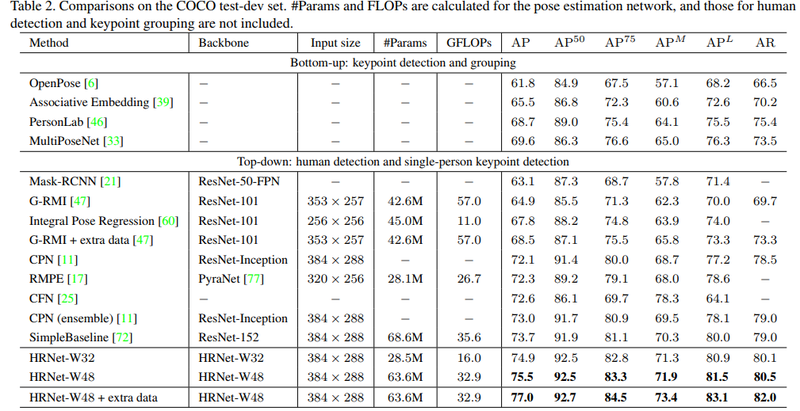

앞에서 다뤘던 Simplebaseline 이 보입니다. 잠깐 언급된 CPN 도 보입니다. AP 성능을 보면 HRNet 이 4% 에 가까운 비약적인 성능 향상을 이뤄냈습니다.<br>
<br>
비교적 학습이 간단하면서 성능까지 좋은 모델이어서 현재도 많이 사용되고 있습니다. 특히 원저자의 PyTorch 코드가 매우 깔끔하게 구현되어 있고 재생산성이 높아 사용하기 좋습니다.<br>
<br>
- https://github.com/leoxiaobin/deep-high-resolution-net.pytorch

## **22-6. 코드로 이해하는 pose estimation**

오늘 본 6개의 모델이 잘 이해가 되시나요? 아마 글로만 읽어서는 크게 와닿지 않을 것 같습니다.<br><br>

> A picture is worth a thousand words

<br>저는 이 말을 참 좋아합니다. 백문이 불여일견.<br>
시각적으로 표현했을 때 한 번에 이해할 수 있다는 점이 영상처리의 가장 큰 장점인 것 같습니다.<br>
<br>
코드도 마찬가지입니다. 잘 작성된 코드는 하나의 예술작품처럼 아름답게 보이고 오히려 더 직관적으로 보입니다.<br>
<br>
6개 모델 중 가장 간단한 모델인 SimpleBaseline을 모델 부분만 정확하게 이해해 보겠습니다.

### **SimpleBaseline 구조**
---

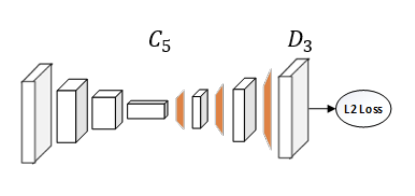

그림을 통해<br>
<br>
- encoder : conv layers
- decoder : deconv module + upsampling<br><br>

로 이루어져 있다는 것을 알 수 있지만 conv layer 가 정확히 어떻게 이루어져 있는지, deconv module 은 구성이 어떻게 되어 있는지, deconv module 이 그림처럼 3개일지는 논문을 정확하게 읽어봐야 알 수 있습니다.<br>
<br>
논문 : [Simple Baselines for Human Pose Estimation and Tracking](https://arxiv.org/pdf/1804.06208.pdf)<br>
<br>
논문을 살펴보고 아래 질문에 답을 해주세요!

**Q. conv model 로 어떤 backbone 을 사용하나요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

resnet을 사용합니다.</details>

**Q. deconv module 은 어떤 레이어로 이루어져 있나요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

deconv-bn-relu 이 단계가 3개로 이루어져 있습니다. deconv 는 256 filter size, 4x4 kernel, stride 2 로 2배씩 feature map이 커집니다.</details>

**Q. 마지막 출력 레이어는 어떤 레이어로 구성되나요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

k 개의 1x1 conv layer로 구성됩니다.</details>

### **PyTorch code 읽어보기**
---

사실 논문도 모든 디테일을 설명해 주지 않습니다.<br>
하지만 인공지능 분야의 최대 장점은 저자의 공식 코드가 제공된다는 점이라고 할 수 있습니다.<br>
마침 simplebaseline 의 저자도 논문에서 코드 repo 의 위치를 언급했습니다.<br>
<br>
해당 위치로 들어가면 더 자세히 살펴볼 수 있습니다.<br>
<br>
- https://github.com/Microsoft/human-pose-estimation.pytorch<br><br>

18년 이후 PyTorch 의 급격한 성장으로 절반 이상의 오픈소스가 파이토치로 공개되고 있습니다.

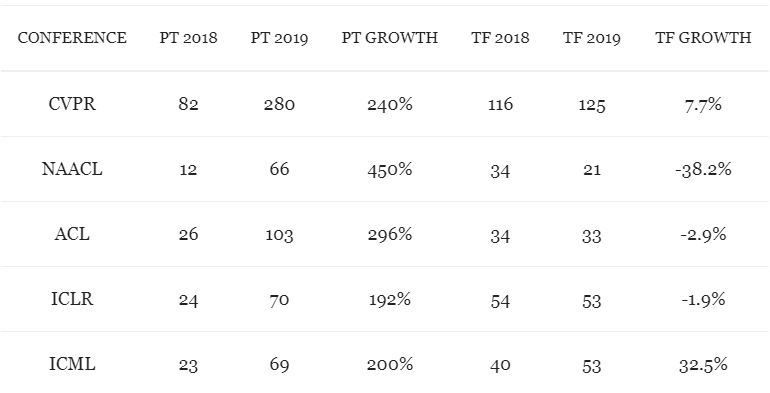

[주요 컨퍼런스의 PyTorch 성장률과 tensorflow 성장률. 사실 연구분야에서는 PyTorch 가 압도적으로 많이 사용되고 있습니다.]

아니나 다를까, 오늘 검토해 보아야 할 공식 코드repo도 파이토치 기반으로 작성되어 있습니다.<br>
<br>
여러분이 파이토치 코드를 읽을 줄 모른다면 그만큼 참고할 수 있는 코드가 줄어든다는 뜻입니다.<br>
이번 스텝만으로 파이토치 코드를 구현할 수 없더라도 지금까지 쌓아온 기본기를 이용해서 simplebaseline 의 파이토치 코드를 같이 읽어보기만 하겠습니다.<br>
<br>
모델 부분입니다.<br>
<br>
- [microsoft/human-pose-estimation.pytorch](https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py)<br><br>

`nn.` 표현이 많이 등장합니다. `torch.nn` 으로 `keras.layers` 와 같이 딥러닝 모델 구성에 필요한 도구들이 정의되어 있습니다.<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L29<br><br>

29번째 줄에서는 BasicBlock 이라는 클래스가 보이네요. keras.models 로 model 을 선언하는 것과 비슷합니다.<br>
<br>
참고로 pytorch model 에서는 사용된 layer 를 forward 함수를 통해 computational graph 를 그려줍니다.<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L42<br><br>

forward 함수를 읽어볼까요? 앗.. 어딘가 많이 본 구조 아닌가요?

```
residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
```

맞습니다. residual block 을 사용했네요.<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L157<br><br>

Pose 메인 model 을 살펴보니 4개의 residual block 을 이용합니다. 완전 resnet 과 동일하죠?<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L234<br><br>

forward 함수를 보면 흐름을 쉽게 알 수 있습니다.

```
def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        x = self.final_layer(x)

        return x
```

resnet 을 통과한 후 `deconv_layers` 와 `final_layer`를 차례로 통과합니다.<br>
<br>
deconv layer 를 찾아보니,<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L219

```
        layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
```

transpose conv 와 bn, relu 로 이루어져 있는 것을 확인했습니다.<br>
<br>
세세한 파라미터는 어디에 있을까요?<br>
<br>
EXTRA 가 자주 등장하는 것을 볼 때, 어떤 configuration 파일이 있을 것으로 짐작해 볼 수 있겠네요. repo 내에서 검색해 보면 파라미터 관련 정보를 담고 있는 아래 파일을 찾을 수 있습니다.<br>
<br>
- https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3.yaml#L23

```
NUM_DECONV_LAYERS: 3
    NUM_DECONV_FILTERS:
    - 256
    - 256
    - 256
    NUM_DECONV_KERNELS:
    - 4
    - 4
    - 4
```

deconv layer 의 파라미터가 아주 상세히 적혀있네요!<br>
<br>
이렇게 simplebaseline 의 모델을 상세하게 파악해 볼 수 있었습니다. 입출력의 크기도 계산할 수 있겠죠?

**Q. 192x256 의 이미지가 입력될 때 출력의 크기는 얼마인가요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

resnet 출력이 6x8 이 나오고 3개의 deconv layer 를 통과하므로 48x64 가 출력됩니다.</details>

파이토치 코드는 케라스 보다 직관적으로 표현되어 있기 때문에 지금처럼 빠르게 파악할 수 있는 장점이 있습니다.<br>
<br>
이제 파악한 지식을 이용해서 tf-simplebaseline 모델을 만들어봅시다.

###### SimpleBaseline - tf2

In [ ]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

deconv module을 만들어주세요.

In [ ]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

deconv module에서 중복을 제거할 수 없을까요? 코드로 표현해 봅시다.

In [ ]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

In [ ]:
final_layer = tf.keras.layers.Conv2D(17, kernel_size=(1,1), padding='same')

이제 각각의 요소를 합쳐 모델을 완성합니다.

In [ ]:
inputs = keras.Input(shape=(256, 192, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

가상의 이미지를 넣어서 출력이 잘 나오는지 확인하는 코드를 작성해 봅시다.

In [ ]:
np_input = np.zeros((1,256,192,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

고생하셨습니다.<br>
<br>
label 을 어떻게 만드는지, 48x64 의 출력을 어떻게 사용해야 하는지 실습시간에서 다뤄보도록 하겠습니다.

## **22-7. 마무리하며**

이번 시간에는 딥러닝 기술이 적용되기 전의 Pose estimation 방법과 더불어 딥러닝 기반 초기 추론 방법인 DeepPose, 그리고 Pose estimation 기법의 랜드마크라고 불릴만한 Stacked Hourglass Network에 대한 내용까지 같이 학습해 보았습니다.<br>
<br>
딥러닝 기술이 적용되기 전 Pose estimation은 연산 효율이 떨어지는 점과 부족한 성능으로 한계점이 분명했었고, 딥러닝 기술을 처음 활용한 DeepPose의 경우 기존의 기술로는 풀기 어려웠던 동작의 다양성이나 invisible joint의 문제를 딥러닝 기반의 추론 방법으로 해결할 수 있다는 것을 증명했습니다.<br>
<br>
이후에 제안된 Stacked Hourglass Network 모델의 경우 간단한 구조를 여러 층으로 쌓아올려서 성능을 향상시키기도 하였죠. 다음 프로젝트 스텝에서 해당 모델을 활용해 볼 예정입니다!<br>
<br>
좀 어떠셨나요? Pose estimation 기술에 대해 잘 이해해볼 수 있는 시간이었기를 바라면서 종합 퀴즈로 한 번 넘어가 보겠습니다~

### **종합 퀴즈**
---

지금까지 여러분들이 얼마나 학습을 충실히 하셨는지 알아볼까 합니다. 여러분의 실력을 쑥쑥 향상시켜줄 수 있는 퀴즈이기도 하므로 배운 내용을 다시 생각하면서 아래의 퀴즈를 풀어보세요. 🤗

**Q. DeepPose 이후 랜드마크라고 불릴만한 Stacked Hourglass Network의 기본 구조는 모래시계 같은 모양으로 만들어져 있었죠. (기억이 잘 나지 않는다면, 5번째 스텝으로 돌아가볼까요 ㅎㅎ)<br>
<br>
기존 pose estimation을 위해 제안된 모델들과의 가장 큰 차이점 2개는 무엇일까요?**<br>
A. [ 답변을 적어볼까요! ]<br><br>

<details><summary>💡예시답안 확인하기💡</summary>

feature map upsampling과 residual connection 구조입니다.<br>
pooling으로 image의 global feature를 찾고, upsampling으로 local feature를 고려하는 아이디어가 hourglass의 핵심 컨셉이라고 할 수 있죠!</details>

종합 퀴즈는 괜찮았나요? 학습을 충실히 하셨다면 쉽게 해결하셨을 것이라 생각합니다. 혹시라도 답을 맞히지 못하셨다면, 다시 한번 배웠던 내용을 복습해 보세요.<br>
<br>
지금까지 수고 많이 하셨습니다!